[View in Colaboratory](https://colab.research.google.com/github/mogamin/chainer-examples/blob/master/chainer_PotatoChips_Classification_CNN_da.ipynb)

In [1]:
# 
![ ! -e ./data ] && curl -L "https://rebrand.ly/dllab2018-hackathon-cv" -o data.tar.gz && gzip -d -c data.tar.gz | tar xf -

!apt-get install -y -qq libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80==4.3.0 
!pip install chainer==4.3.0
!pip install chainercv

import chainer
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

!rm -rf result/

GPU availability: True
cuDNN availablility: True


In [0]:
import chainer
import random
import numpy as np

RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if chainer.cuda.available:
    chainer.cuda.cupy.random.seed(RANDOM_SEED)

In [0]:
# 画像データの前処理変換
import chainer
from chainercv.transforms import resize
from chainercv.transforms import random_flip
from chainercv.transforms import random_sized_crop

class ImageResizeTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        img = resize(img, (224, 224))
        return img, label
      
class ImageRandomTransform(object):
    def __call__(self, in_data):
        img, label = in_data
        _, H, W = img.shape
        img = random_sized_crop(img)
        img = resize(img, (224, 224))
        img = random_flip(img, x_random=True)
        return img, label      

In [0]:
import chainer.links as L
import chainer.functions as F
from chainercv.links import VGG16

#
class PotatoCNN_VGG16(chainer.Chain):
  def __init__(self, pretrained_model, n_class=9):
    super(PotatoCNN_VGG16, self).__init__()
    with self.init_scope():
      self.base = VGG16(pretrained_model=pretrained_model)
      self.base.pick = 'pool5'
      self.fc1 = L.Linear(None, 4096)
      self.fc2 = L.Linear(None, 4096)
      self.fc3 = L.Linear(None, n_class)
  
  def __call__(self, x):
    h = self.base(x)
    h.unchain()
    h = F.relu(self.fc1(h))
    h = F.relu(self.fc2(h))
    return self.fc3(h)

# VGG16 model
class PotatoCNN(chainer.Chain):
  def __init__(self, n_class=9):
    super(PotatoCNN, self).__init__()
    with self.init_scope():
      self.conv1_1 = L.Convolution2D(3, 64, 3, 1, 1)
      self.conv1_2 = L.Convolution2D(64, 64, 3, 1, 1)
      self.conv2_1 = L.Convolution2D(64, 128, 3, 1, 1)
      self.conv2_2 = L.Convolution2D(128, 128, 3, 1, 1)
      self.conv3_1 = L.Convolution2D(128, 256, 3, 1, 1)
      self.conv3_2 = L.Convolution2D(256, 256, 3, 1, 1)
      self.conv3_3 = L.Convolution2D(256, 256, 3, 1, 1)
      self.conv4_1 = L.Convolution2D(256, 512, 3, 1, 1)
      self.conv4_2 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv4_3 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_1 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_2 = L.Convolution2D(512, 512, 3, 1, 1)
      self.conv5_3 = L.Convolution2D(512, 512, 3, 1, 1)
      self.fc6 = L.Linear(512 * 7 * 7, 4096)
      self.fc7 = L.Linear(4096, 4096)
      self.fc8 = L.Linear(4096, n_class)
  
  def __call__(self, x):
    h = F.relu(self.conv1_1(x))
    h = F.relu(self.conv1_2(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv2_1(h))
    h = F.relu(self.conv2_2(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv3_1(h))
    h = F.relu(self.conv3_2(h))
    h = F.relu(self.conv3_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv4_1(h))
    h = F.relu(self.conv4_2(h))
    h = F.relu(self.conv4_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.conv5_1(h))
    h = F.relu(self.conv5_2(h))
    h = F.relu(self.conv5_3(h))
    h = F.max_pooling_2d(h, ksize=2)
    h = F.relu(self.fc6(h))
    h = F.relu(self.fc7(h))
    return self.fc8(h)  

#
class PotatoMLP(chainer.Chain):
  def __init__(self, n_class=9):
    super(PotatoMLP, self).__init__()
    with self.init_scope():
      self.fc1 = L.Linear(None, 224)
      self.fc2 = L.Linear(None, 224)
      self.fc3 = L.Linear(None, 224)
      self.fc4 = L.Linear(None, 224)
      self.fc5 = L.Linear(None, 224)
      self.fc6 = L.Linear(None, n_class)
  
  def __call__(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    h = F.relu(self.fc3(h))
    h = F.relu(self.fc4(h))
    h = F.relu(self.fc5(h))
    return self.fc6(h)  

In [0]:
from chainer import optimizer

def optimizer_adam(model):
  optimizer = chainer.optimizers.Adam()
  optimizer.setup(model)
  return optimizer

def optimizer_momentumSGD(model):
  optimizer = chainer.optimizers.MomentumSGD(lr=0.001, momentum=0.9).setup(model)
  for param in model.params():
    if param.name != 'beta' and param.name != 'gamma':
        param.update_rule.add_hook(chainer.optimizer.WeightDecay(0.0001))
  return optimizer


In [0]:
## PATTERN-1
#model = L.Classifier(PotatoCNN_VGG16(pretrained_model='imagenet'))
#optimizer = optimizer_momentumSGD(model)

## PATTERN-2
model = L.Classifier(PotatoCNN())
optimizer = optimizer_momentumSGD(model)

## PATTERN-3
#model = L.Classifier(PotatoMLP())
#optimizer = optimizer_momentumSGD(model)

In [0]:
if chainer.cuda.available == True:
  GPUID=0
  xp = chainer.cuda.cupy
  chainer.cuda.Device(GPUID).use()
  model.to_gpu(GPUID)
else:
  GPUID=-1
  xp = np

In [0]:
#
from chainer.training import extensions

BATCHSIZE=16
EPOCH=10

# データのロード
from chainer.datasets import LabeledImageDataset
from chainer.datasets import TransformDataset

train = LabeledImageDataset('data/train/train_labels.txt', root='data/train/images/')
train = TransformDataset(train, ImageRandomTransform())
valid = LabeledImageDataset('data/valid/valid_labels.txt', root='data/valid/images/')
valid = TransformDataset(valid, ImageResizeTransform())

train_iter = chainer.iterators.SerialIterator(train, BATCHSIZE)
valid_iter = chainer.iterators.SerialIterator(valid, BATCHSIZE, repeat=False, shuffle=False)

updater = chainer.training.StandardUpdater(train_iter, optimizer, device=GPUID)
trainer = chainer.training.Trainer(updater, (EPOCH, 'epoch'), out='result/potato')

log_interval = 0.1, 'epoch'
plot_interval = 1, 'epoch'

trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=chainer.training.triggers.ManualScheduleTrigger([10], 'epoch'))
trainer.extend(extensions.Evaluator(valid_iter, model, device=GPUID), name='val')
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(extensions.PrintReport(['iteration', 'epoch', 'elapsed_time', 'lr', 'main/loss','val/main/loss', 'main/accuracy', 'val/main/accuracy']), trigger=log_interval)
trainer.extend(extensions.ProgressBar(update_interval=500))
trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   val/main/loss  main/accuracy  val/main/accuracy
66          0           70.7417                   2.4218                     0.113636                          
132         0           139.822                   2.1954                     0.124053                          
198         0           209.07                    2.19089                    0.128788                          
264         0           278.222                   2.17319                    0.152462                          
330         0           347.046                   2.19721                    0.125                             
396         0           415.862                   2.19626                    0.109848                          
461         0           483.744                   2.19449                    0.1125                            
     total [###...............................................]  7.59%
this epoch [#######################

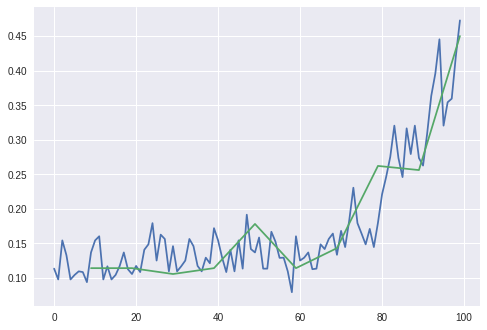

In [10]:
import json
import pandas as pd
with open('result/potato/log') as f:
  result = pd.DataFrame(json.load(f)).interpolate()

import matplotlib.pyplot as plt
plt.plot(result[['main/accuracy','val/main/accuracy']])
plt.savefig('result/potato/accuracy.png')

In [11]:
import os
  
# Evaluate on test dataset
test = LabeledImageDataset('data/test/test_labels.txt', root='data/test/images')
test = TransformDataset(test, ImageResizeTransform())
test_iter = chainer.iterators.SerialIterator(test, BATCHSIZE, repeat=False, shuffle=False)
test_evaluator = extensions.Evaluator(test_iter, model, device=GPUID)
results = test_evaluator()

msg = 'Test loss\t:{}\n'.format(results['main/loss'])
msg += 'Test accuracy\t:{}'.format(results['main/accuracy'])
print(msg)
print(msg, file=open(os.path.join('./result/potato/', 'test_result.txt'), 'w'))

#model.to_cpu()
#chainer.serializers.save_npz(os.path.join('./result/potato/', 'model_iter_{}'.format(updater.iteration)), model)

Test loss	:1.3354739
Test accuracy	:0.448656
